In [2]:
using DataFrames
using CSV
using Random
using Lux
using Optimisers
using Zygote
using Flux: mse, mae
using Plots
using StatsBase: sample
using Statistics: mean
using JLD2

rng = Random.default_rng();
include("../../../population.jl")

get_property (generic function with 3 methods)

## Data preparation

In [9]:
# Read Data
file = "../../../data/warfarin.csv"
df = CSV.read(file, DataFrame)
df = df[(df.DVID .== 1), :]

# One dataframe per patient
df_group = groupby(df, :ID);

## Functions

In [10]:
# Create individual
function create_individual(df_individual)
    id = df_individual.ID[1]

    amt = df_individual[df_individual.MDV .== 1, "AMT"][1]
    x = Vector{Float64}(df_individual[1, ["WEIGHT", "AGE", "SEX"]])
    push!(x, amt)
    cols_x = ["WEIGHT", "AGE", "SEX", "AMT"]

    ty = df_individual[df_individual.MDV .== 0, ["TIME", "DV"]]

    return Individual(id=id, x=x, t=ty.TIME, y=ty.DV, cols_x=cols_x)
end

# Neural Network Builder
function dnn()
    return Chain(
        Dense(5, 8, swish),
        Dense(8, 4, swish),
        Dense(4, 1, softplus)
    ) |> f64
end

# Time and sex are not normalized 
function normalize_X(X_train; cols_x = ["WEIGHT", "AGE", "SEX", "AMT"],
                     X_test = nothing, scaler = nothing, columns_normalize = ["WEIGHT", "AGE", "AMT"])

    pushfirst!(cols_x, "TIME") # Add time as the first column

    # Find indices of columns to normalize
    indices = findall(x -> x in columns_normalize, cols_x)

    if scaler == nothing
        scaler = maximum(abs.(X_train), dims = 1)[indices]
    end

    X_train[:, indices] = X_train[:, indices] ./ scaler'

    if X_test !== nothing
        X_test[:, indices] = X_test[:, indices] ./ scaler'
    end

    return X_train, X_test, scaler
end

# Train one epoch
function train_epoch(X, y, p)
    global opt_state
    loss, back = Zygote.pullback(p -> mse(model(X', p, st)[1], y'), p) # Calculate gradients
    grad = first(back(1)) # Get gradient
    # Detect loss of Inf or NaN. Print a warning, and then skip update
    if !isfinite(loss)
        @warn "loss is $loss"
        return p, loss
    end
    opt_state, p = Optimisers.update(opt_state, p, grad) # Update weights
    return p, loss # Return updated weights and loss
end

# Train model
function train_model(X_train, y_train, p, num_epochs; X_test = nothing, y_test = nothing)

    X_train, X_test, scaler = normalize_X(X_train; X_test = X_test)

    mae_train = []
    mae_test = []
    mse_train = []
    mse_test = []

    for epoch in 1:num_epochs
        p, loss = train_epoch(X_train, y_train, p)
        if epoch == 300      
            Optimisers.adjust!(opt_state, 0.001)
        end
        if epoch % 100 == 0
            println("Epoch $epoch -> Loss: $loss")
        end

        # Save MSE and MAE of epoch
        preds_train = model(X_train', p, st)[1]
        push!(mae_train, mae(preds_train, y_train'))
        push!(mse_train, mse(preds_train, y_train'))

        if X_test !== nothing
            preds_test = model(X_test', p, st)[1]
            push!(mae_test, mae(preds_test, y_test'))
            push!(mse_test, mse(preds_test, y_test'))
        end
    end
    return p, scaler, mae_train, mse_train, mae_test, mse_test
end

function train_fold(population, p, num_epochs)
    # 25% of subjects go to test
    test_ids = sample(1:length(population), div(length(population), 4), replace = false)
    indvs_test = population[test_ids]
    indvs_train = setdiff(population.individuals, indvs_test)

    X_train, y_train = create_X_y(indvs_train)
    X_test, y_test = create_X_y(indvs_test)

    p, scaler, mae_train, mse_train, mae_test, mse_test = train_model(X_train, y_train, p, num_epochs; X_test = X_test, y_test = y_test)

    return p, mae_train[end], mse_train[end], mae_test[end], mse_test[end]
end

function train_kfolds(population, p, folds, num_epochs)
    list_mae_train = Float32[]
    list_mae_test = Float32[]

    for i in 1:folds
        println()
        println("Training fold $i")
        p, mae_train, mse_train, mae_test, mse_test = train_fold(population, p, num_epochs)
        push!(list_mae_train, mae_train)
        push!(list_mae_test, mae_test)
    end
    println()
    println("Mean MAE across all folds - Train: $(mean(list_mae_train))")
    println("Mean MAE across all folds - Test: $(mean(list_mae_test))")
end

train_kfolds (generic function with 1 method)

## Create population

In [13]:
# Create population
indviduals = Vector(undef, length(df_group))
for (ix, group) in enumerate(df_group)
    indviduals[ix] = create_individual(group)
end
population = Population(indviduals);

## Train

### Train kfolds

In [120]:
# Train kfolds
model = dnn()
p, st = Lux.setup(rng, model)
opt = Optimisers.ADAM(0.01)
opt_state = Optimisers.setup(opt, p) 

folds = 5 
num_epochs = 1000
train_kfolds(population, p, folds, num_epochs)


Training fold 1

Training fold 2

Training fold 3

Training fold 4

Training fold 5

Mean MAE across all folds - Train: 1.0215356
Mean MAE across all folds - Test: 1.0350928


### Train using all the population

Epoch 100 -> Loss: 5.872018465837807
Epoch 200 -> Loss: 3.286088008211552
Epoch 300 -> Loss: 2.792832866593015
Epoch 400 -> Loss: 2.751477295778147
Epoch 500 -> Loss: 2.711660576947858
Epoch 600 -> Loss: 2.6709326521676156
Epoch 700 -> Loss: 2.6299458634627535
Epoch 800 -> Loss: 2.589098531911413
Epoch 900 -> Loss: 2.5486826233670343
Epoch 1000 -> Loss: 2.5091838526492958
Final MAE: 1.1345395312659035


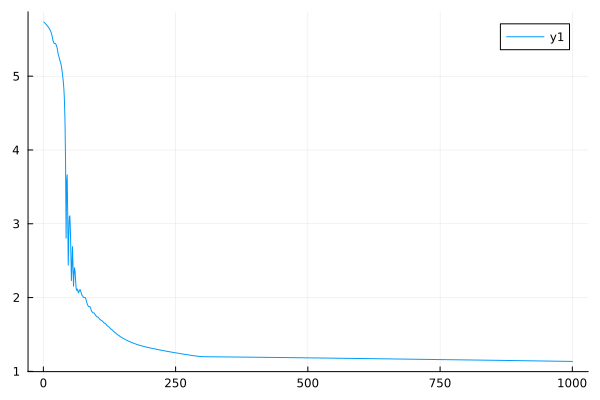

In [14]:
### Train with all patients
model = dnn()
p, st = Lux.setup(rng, model)
opt = Optimisers.ADAM(0.01)
opt_state = Optimisers.setup(opt, p) 

X_train, y_train = create_X_y(population)
p, scaler, mae_train, mse_train, mae_test, mse_test = train_model(X_train, y_train, p, 1000; X_test = nothing, y_test = nothing)

println("Final MAE: $(mae_train[end])")
plot(mae_train)

In [15]:
# Save model
#jldsave("mymodel.jld2"; p, model, scaler)

In [1]:
# Load model
mymodel = JLD2.load("mymodel.jld2")
model = mymodel["model"]
p = mymodel["p"]
scaler = mymodel["scaler"]

UndefVarError: UndefVarError: `JLD2` not defined

## Predict

### Functions

In [16]:
# Predict a single individual. The predicted values are only saved for the individual.t times
function predict_individual(individual, p, scaler; plot_predictions = false)
    X_individual, y_individual = create_X_y(individual)
    X_individual, _, _ = normalize_X(X_individual; scaler = scaler)
    predicted = model(X_individual', p, st)[1] 

    if plot_predictions
        plt = plot(individual.t, predicted', 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        display(plt)
    end
    return predicted
end

# Predict a single real individual with labels
function predict_real_individual(individual, p, scaler; max_time = 120, plot_predictions = false, plot_true_labels = false)

    time_real = individual.t
    real_y = individual.y

    time = collect(0:0.1:(max_time-1))
    subject = Individual(; id=individual.id, x=individual.x, t=time, y=zeros(length(time)), 
                        cols_x = ["WEIGHT", "AGE", "SEX", "AMT"])

    predicted = predict_individual(subject, p, scaler; plot_predictions = false)

    if plot_predictions
        plt = plot(subject.t, predicted', 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        if plot_true_labels
            scatter!(plt, time_real, real_y, label="Real", color=:blue)
        end
        display(plt)
    end
    return predicted, time
end

predict_real_individual (generic function with 1 method)

### Predict real individual from population with real labels

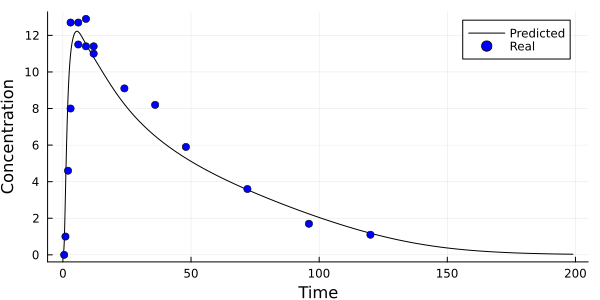

In [17]:
subject = get_individual_by_id(population, 8)
predicted, time = predict_real_individual(subject, p, scaler; max_time = 200, plot_predictions = true, plot_true_labels = true);

### Predict single individual without labels

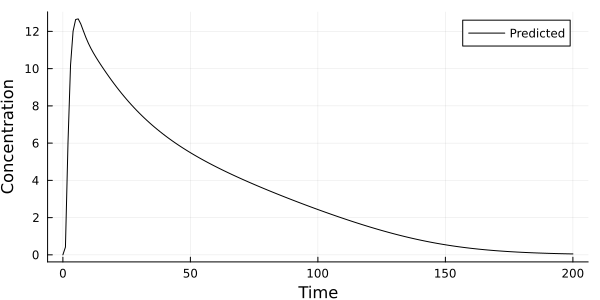

In [18]:
t = collect(0:1:200)
ind = Individual(id = 999, x = [70, 40, 1, 100], t = t, y = zeros(length(t)))
predict_individual(ind, p, scaler; plot_predictions = true);

## Experiments

### Functions

In [19]:
function test_variables(ind, p, scaler; max_time=200, variable="AMT", values=[0, 1, 10, 50, 100, 200, 500])
    colors = Plots.palette(:viridis, length(values))

    index = findfirst(x -> x == variable, ind.cols_x)

    plt = plot(label="Predicted", xlabel="Time", ylabel="Concentration", size=(600,300))
    for (i, val) in enumerate(values)
        x = copy(ind.x)
        x[index] = val
        test_ind = Individual(id = ind.id, x = x, t = ind.t, y = ind.y)
        predicted = predict_individual(test_ind, p, scaler; plot_predictions = false)
        plot!(test_ind.t, predicted', linewidth=1, label="$variable=$val", linecolor=colors[i])
    end
    display(plt)
end

test_variables (generic function with 1 method)

### Initialize individual

In [228]:
t = collect(0:1:200)
individual = Individual(id = 999, x = [70, 40, 0, 100], t = t, y = zeros(length(t))); # Initialize individual

### Change AMT

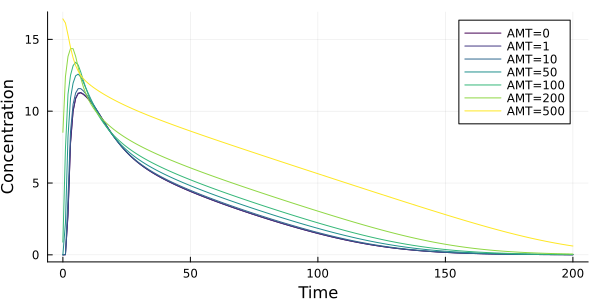

In [229]:
test_variables(individual, p, scaler; max_time=200, variable="AMT", values=[0, 1, 10, 50, 100, 200, 500])

### Change Weight

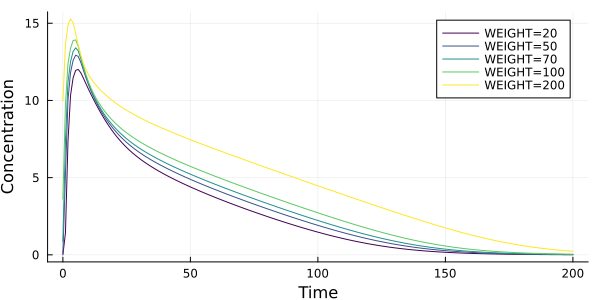

In [230]:
test_variables(individual, p, scaler; max_time=200, variable="WEIGHT", values=[20, 50, 70, 100, 200])

### Change age

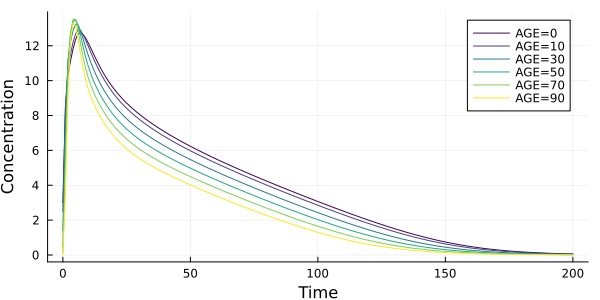

In [231]:
test_variables(individual, p, scaler; max_time=200, variable="AGE", values=[0, 10, 30, 50, 70, 90])

### Change sex

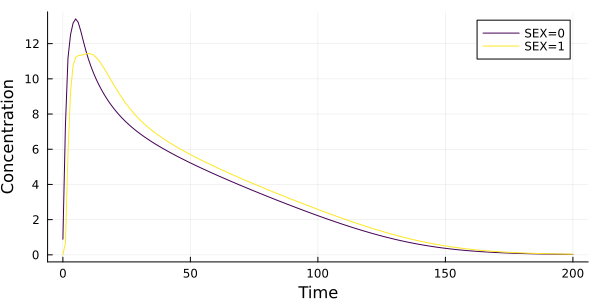

In [232]:
test_variables(individual, p, scaler; max_time=200, variable="SEX", values=[0, 1])

### Simulate long time

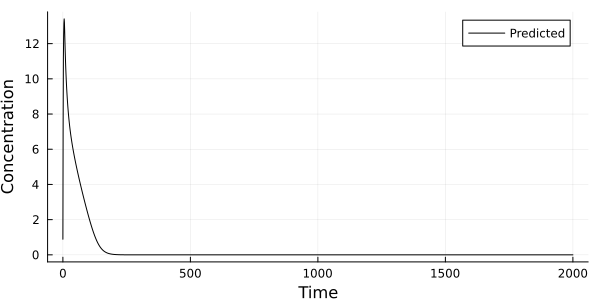

In [236]:
t = collect(0:1:2000)
ind = Individual(id = 999, x = [70, 40, 0, 100], t = t, y = zeros(length(t)))
predict_individual(ind, p, scaler; plot_predictions = true);

## Multiple doses

In [ ]:
# Multiple doses
# For DNNs, when giving multiple doses, we need to treat it as addition. So we predict first a dose, and then add the new one
function multiple_doses(ind, time_simulation; time_new_dose = [], new_dose = []):
        # Initial dose

        test_ind = Individual(id = ind.id, x = x, t = collect(1:0.1:time_simulation))
        predicted = predict_individual(test_ind, p, scaler; plot_predictions = false)
        
        df_predicted = predict_patient(df_test, model, scaler, max_time = time_simulation, 
                                plot=False, plot_true_labels=False)

        for ix, dose in enumerate(new_dose):
                # New dose
                df_test['AMT'] = dose
                                
                df_predicted_redose = predict_patient(df_test, model, scaler, max_time = time_simulation - time_new_dose[ix],
                                        plot=False, plot_true_labels=False)
                df_predicted_redose['TIME'] += time_new_dose[ix]
                df_predicted = df_predicted.merge(df_predicted_redose, how = 'left', on='TIME')
                df_predicted = df_predicted.fillna({'predicted_y':0})
                df_predicted['predicted'] = df_predicted['predicted_x'] + df_predicted['predicted_y']
                df_predicted = df_predicted.drop(columns = ['predicted_x', 'predicted_y'])
                
        fig, ax = plt.subplots(1,1,figsize=(6,3))
        df_predicted.plot(kind = 'line', ax = ax, x = 'TIME', y = 'predicted', linewidth=1, color = 'black', style='-', label='Predicted')
        ax.set_ylabel('Concentration')
        plt.legend(loc='best')